In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predict a chest disease

This project started with trying to recreate the ChestXNet project. Briefly explained, the ChestXNet group has developed an algorithm to classify pneumonia from other thoracic diseases in the ChestX-ray14 data set released by Wang et al. (2017). This data set contains of 112,120 frontal-view chest X-ray images, where each of them are labeled with up to 14 different diseases. You can read more about the CheXNet here: https://stanfordmlgroup.github.io/projects/chexnet/
<br>

Some of the issues I encountered along the way with this paper was that they have not described how they have balanced pneumonia in relation to all other diseases, how they have handled image of the same patient in the training and the validation sets, and how their test set looks like.
<br>

Therefore, it has been difficult for me to compare this project with theirs.
The purpose of recreating their project was to use a trained network on chest X ray14 data set to train another x-ray data set and look into the value of transfer learning.
To achieve a well trained network on chestX-ray 14 data set we have decided to look into another disease with more unique examples in the dataset compared with pneumonia.

In [2]:
import sys
sys.path.append("../../fastai/")

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix
from chest_feature_engineering import *

In [4]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/"  #MMIV
#PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/chest-xrays/data/" #Home

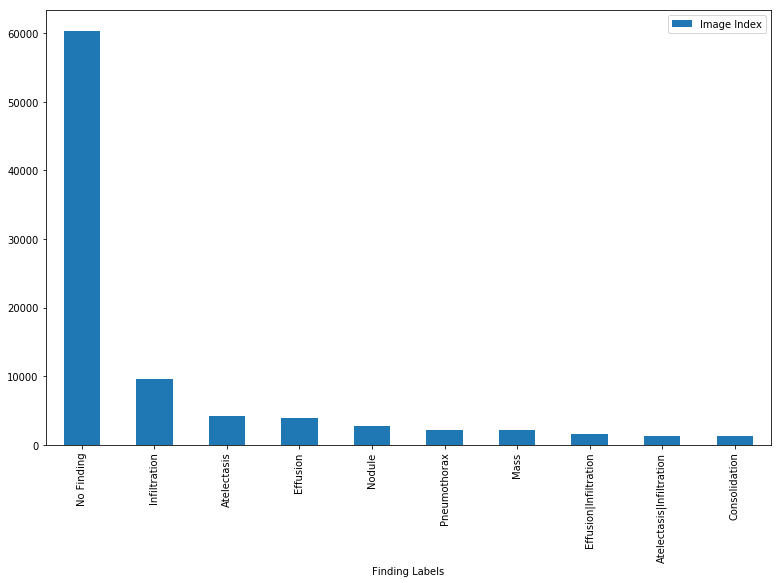

In [5]:
chestX_info()

In [6]:
disease_name = 'Effusion'

In [7]:
disease_finding(disease_name)

Effusion: 3955
Total apperance: 13317
Number of rows that must be deleted: 9362


In [8]:
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv' 
exists = os.path.exists(cleaned_label_path)
if(exists): 
    df = pd.read_csv(cleaned_label_path)
    print('Cleaned label exists for ' + disease_name)
else: 
    df = clean_label(disease_name)

Cleaned label exists for Effusion


### Information
The validation set we create with the training set may contain images of the same patient as there are several images of a patient. This may lead to better results on the validation set than on test set. 
Since we want a well trained network on chestX-ray 14 data set to look into the value of transfer learning, we have decided to use the test set as the validation set. 

In [9]:
sz=64
arch=dn169
bs = 16

In [10]:
val_image_name_list = [line.rstrip('\n') for line in open(f'{PATH}test_list.txt')]

In [11]:
idxs = df[df['Image Index'].isin(val_image_name_list)].index 

In [12]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())
    return ImageClassifierData.from_csv(PATH, 'train', cleaned_label_path, test_name=None,
                                       val_idxs=idxs, tfms=tfms, bs=bs);

In [13]:
data = get_data(sz)

# Training

In [ ]:
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0.5)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 0.00005

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
#learn.lr_find()
#learn.sched.plot()

In [ ]:
learn.unfreeze()

In [ ]:
lrs = [lr/9, lr/3,lr];

In [ ]:
learn.fit(lrs, 1, cycle_len=1)

In [ ]:
learn.save(f'{sz}169') 

In [ ]:
sz=128
learn.set_data(get_data(sz))
learn.freeze() 

In [ ]:
#learn.lr_find()
#learn.sched.plot()

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) 

In [ ]:
lrs = [lr/9, lr/3,lr];
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, cycle_len=1)  #sette epoch verdi ned til 2 kanskje 

In [ ]:
learn.save(f'{sz}169')

In [ ]:
sz = 256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
#overfitter veldig når jeg kjører unfreeze

In [ ]:
lrs = [lr/9, lr/3,lr];
learn.unfreeze()

In [ ]:
learn.save(f'{sz}169')

In [ ]:
learn.fit(lrs, 1, cycle_len=1)

In [ ]:
learn.save(f'{sz}169')

In [ ]:
learn.sched.plot_loss()

#  Analyzing the results

In [14]:
sz = 256
data = get_data(sz)

In [15]:
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0.5)

In [17]:
learn.load("256169denne")

In [18]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy = accuracy_np(probs, y)

In [19]:
print('Accuracy with TTA: '+str(accuracy))

Accuracy with TTA: 0.8939443468312017


In [24]:
probs

array([[0.81929, 0.18071],
       [0.95753, 0.04247],
       [0.68414, 0.31586],
       ...,
       [0.9712 , 0.0288 ],
       [0.91694, 0.08306],
       [0.9414 , 0.0586 ]], dtype=float32)

In [25]:
preds = np.argmax(probs, axis=1)  #selects the position of the highest value
#probs = probs[:,1] 

In [26]:
cm = confusion_matrix(y,preds);

[[21515  3030]
 [ 2161 22240]]


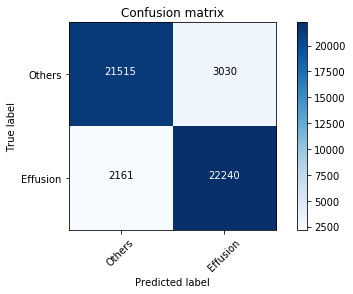

In [27]:
plot_confusion_matrix(cm, ['Others', disease_name])

In [28]:
from sklearn.metrics import f1_score

In [29]:
f1_score(y, preds)  

0.8954923395945321

In [30]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [31]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [32]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


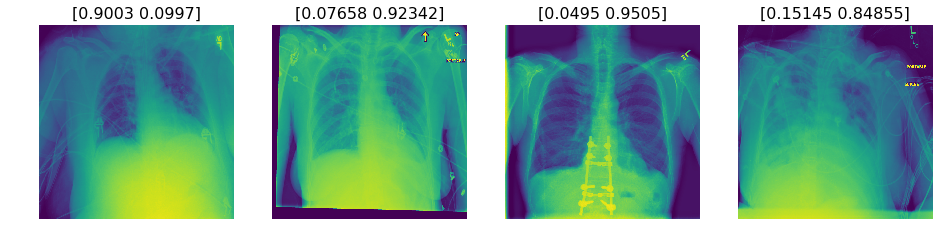

In [33]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [34]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [36]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U64') dtype('<U64') dtype('<U64')

In [37]:
indx_arr = list(range(data.val_ds.fnames.size))

In [38]:
type(indx_arr)

list